# 📝 Project 02: Fashion MNIST Classfier

# Steps 
1. **Set up environment**

   * Install PyTorch and torchvision.
   * Make sure you can run Jupyter Notebook or a Python script.

2. **Load the MNIST dataset**

   * Use the standard MNIST dataset that has 60,000 training images and 10,000 test images.
   * Apply basic preprocessing: convert to tensors and normalize pixel values.

3. **Explore the dataset**

   * Visualize a few digit images with their labels.
   * Check dataset shape (28x28 grayscale images).

4. **Design the CNN model**

   * Build a simple Convolutional Neural Network with convolutional layers, activation functions (ReLU), pooling layers, and fully connected layers.
   * Output layer should have 10 neurons (for digits 0–9).

5. **Define training setup**

   * Choose a **loss function**: CrossEntropyLoss (for classification).
   * Choose an **optimizer**: Adam or SGD.
   * Set learning rate and number of epochs.

6. **Train the model**

   * For each batch of training data:

     1. Reset gradients.
     2. Pass data through the model (forward pass).
     3. Calculate loss between predictions and actual labels.
     4. Backpropagate the loss (compute gradients).
     5. Update weights using the optimizer.
   * Print loss per epoch to monitor training progress.

7. **Evaluate the model**

   * Test the trained model on the test dataset.
   * Measure accuracy: number of correct predictions divided by total predictions.

8. **Visualize results**

   * Plot training loss across epochs.
   * Show some test images along with predicted labels vs actual labels.

9. **Save the trained model**

   * Export model weights so you don’t need to retrain later.

10. **Optional extensions**

* Try adding dropout layers to reduce overfitting.
* Experiment with different optimizers (SGD, RMSprop).
* Deploy the model in a simple notebook UI where you can draw a digit and get prediction.

In [1]:
import torch 
from torch import nn

# computer vision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# setting device and seeding 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
SEED = 42

In [3]:
# LOADING DATA 
train_data = datasets.FashionMNIST(root="data", 
                                  train=True,
                                  transform=ToTensor(), 
                                  download=True)

test_data = datasets.FashionMNIST(root="data", 
                                 train=False,
                                 transform=ToTensor(), 
                                 download=True)

In [4]:
len(train_data.data), len(test_data.data)
# train_data[0]

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
def plot_random_images(data: torch.Tensor, class_names: list[str]):
    fig = plt.figure(figsize=(9, 9))

    rows, cols = 4, 4

    for i in range(1, rows * cols + 1):
        random_index = torch.randint(0, len(data), size=[1]).item()

        image, label = data[random_index]

        fig.add_subplot(rows, cols, i)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis(False)
        plt.legend()

/var/folders/jb/zv52kfjn0kv537nv2xvx5y0r0000gn/T/ipykernel_83584/2108750962.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


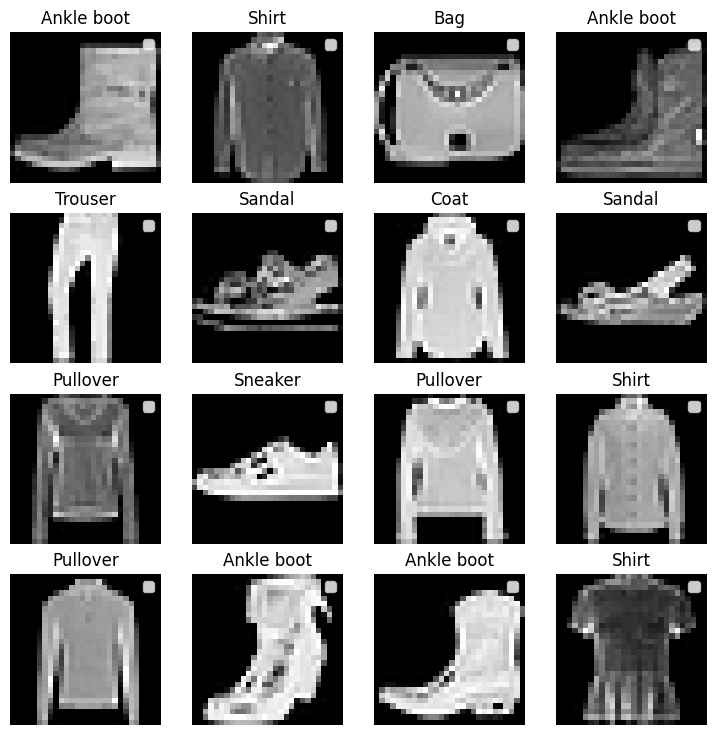

In [7]:
torch.manual_seed(SEED)

plot_random_images(train_data, class_names)

/var/folders/jb/zv52kfjn0kv537nv2xvx5y0r0000gn/T/ipykernel_83584/2108750962.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


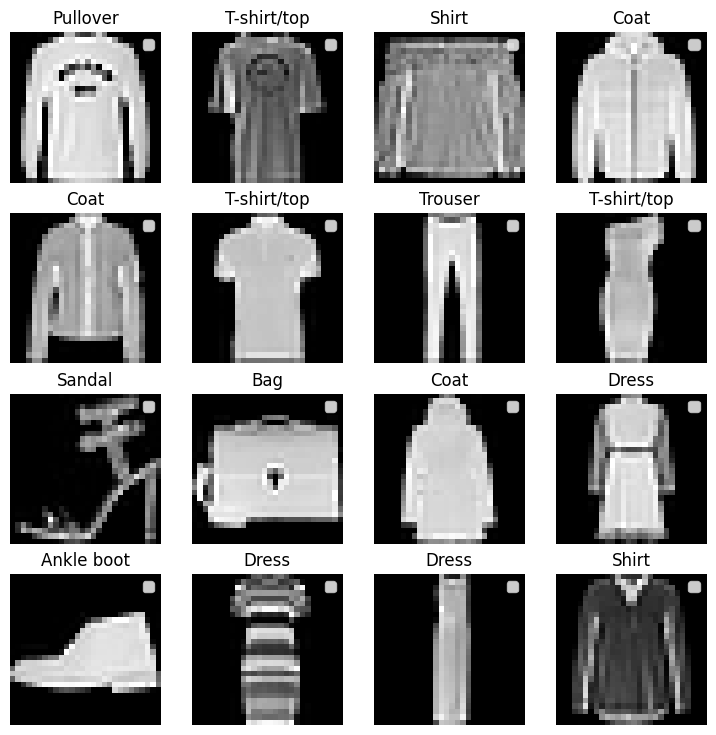

In [8]:
# SHOW SOME IMAGES IN TEST DATA
plot_random_images(data=test_data, class_names=class_names)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False)

print(f"Length of the test dataloader: {len(test_dataloader)} of batches: {BATCH_SIZE}")
print(f"Length of the train dataloader: {len(train_dataloader)} of batches: {BATCH_SIZE}")

Length of the test dataloader: 313 of batches: 32
Length of the train dataloader: 1875 of batches: 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
# train_features_batch[0]

Image size: torch.Size([1, 28, 28])


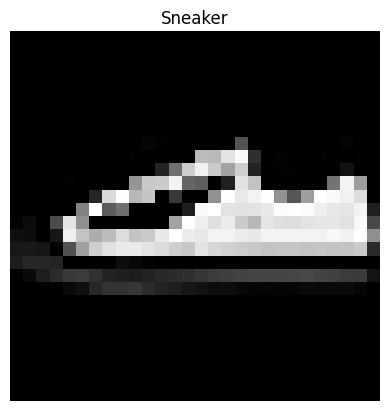

In [11]:
torch.manual_seed(SEED)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {image.shape}")

In [12]:
# train and test step function
import torch
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               device: torch.device = DEVICE):
    model.train()

    train_acc, train_loss = 0, 0 

    for batch, (X, y) in enumerate(dataloader):
        # moving data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X)

        # 2. Calculate and accummulate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        y_pred_labels = torch.argmax(y_logits, dim=1)
        train_acc += (y_pred_labels == y).sum().item() / len(y_logits)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return {
        "train_acc": train_acc,
        "train_loss": train_loss
    }


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device = DEVICE):
    model.eval()

    test_acc, test_loss = 0, 0 

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_logits = model(X)

            # calculate and accumulate loss
            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(test_logits, dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_logits)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return {
        "test_acc": test_acc,
        "test_loss": test_loss
    }      

/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import torch
from tqdm.auto import tqdm

def train_model(model: torch.nn.Module, 
               train_dataloader: torch.utils.data.DataLoader, 
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               epochs: int = 5,
               device: torch.device = DEVICE):
    results = {
        "train_acc": [],
        "train_loss": [],
        "test_acc": [],
        "test_loss": []
    }

    for epoch in tqdm(range(epochs)):
        
    
        train_results = train_step(model, train_dataloader,loss_fn, optimizer, device)

        test_results = test_step(model, test_dataloader, loss_fn, device)


        

        # showing what's happening
        print(
            f"Epoch: {epoch + 1} | ", 
            f"train_loss: {train_results['train_loss']:.4f} | train_acc: {train_results['train_acc']:.4f} | ",
            f"test_loss: {test_results['test_loss']:.4f} | test_acc: {test_results['test_acc']:.4f}",
             )
        
        results["train_acc"].append(train_results["train_acc"])
        results["train_loss"].append(train_results["train_loss"])
        results["test_acc"].append(test_results["test_acc"])
        results["test_loss"].append(test_results["test_loss"])


    return results

In [14]:
# building Tiny vgg model
class TinyVGG(nn.Module):
    """
        Tiny VGG ARCHTECTURE

        Args:
            input_shape (int): Number of input color channels
            hidden_units (int): Number of the hidden units/ filters in model
            output_shape (int): Number of the classes to be predicted

        Description: 
            Implements a simplified VGG-style CNN (TinyVGG), consisting of stacked
            convolutional layers with ReLU activations,
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # passing through first conv block
        x = self.block_1(x)

        # passing through second conv block
        x = self.block_2(x)

        # passing throgh classfication block
        x = self.classfier(x)

        return x

In [15]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model_0 = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(DEVICE)

In [16]:
from torchinfo import summary

summary(model=model_0, input_size=(32, 1, 28, 28), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 28, 28]          100
│    └─ReLU: 2-2                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 7, 7]            --
│    └─Conv2d: 2-6                       [32, 10, 14, 14]          910
│    └─ReLU: 2-7                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-8                       [32, 10, 14, 14]          910
│    └─ReLU: 2-9                         [32, 10, 14, 14]          --
│    └─MaxPool2d: 2-10                   [32, 10, 7, 7]            --
├─Sequentia

In [17]:
# initiating loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [18]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [19]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

results = train_model(model_0, 
           train_dataloader,
           test_dataloader,
           loss_fn, 
           optimizer)

 20%|█████████                                    | 1/5 [01:13<04:53, 73.46s/it]

Epoch: 1 |  train_loss: 1.0379 | train_acc: 0.6234 |  test_loss: 0.6257 | test_acc: 0.7687


 40%|██████████████████                           | 2/5 [02:27<03:42, 74.06s/it]

Epoch: 2 |  train_loss: 0.5495 | train_acc: 0.8000 |  test_loss: 0.4984 | test_acc: 0.8152


 60%|███████████████████████████                  | 3/5 [03:42<02:28, 74.11s/it]

Epoch: 3 |  train_loss: 0.4557 | train_acc: 0.8352 |  test_loss: 0.4401 | test_acc: 0.8433


 80%|████████████████████████████████████         | 4/5 [05:01<01:16, 76.21s/it]

Epoch: 4 |  train_loss: 0.4131 | train_acc: 0.8516 |  test_loss: 0.4136 | test_acc: 0.8527


100%|█████████████████████████████████████████████| 5/5 [06:22<00:00, 76.44s/it]

Epoch: 5 |  train_loss: 0.3862 | train_acc: 0.8619 |  test_loss: 0.3977 | test_acc: 0.8601


In [20]:
class TinyVGGWithDropout(nn.Module):
    """
    TinyVGG with dropout layer

    Args: 
        input_shape (int): Number of color channels
        hidden_units (int): Number of hidden units.
        output_shape (int): Number of classes to be predicted.
        dropout_rate (float): rate of dropout

    Description:
        Implements a simplified VGG-style CNN (TinyVGG), consisting of stacked
        convolutional layers with ReLU activations, max pooling, dropout, and fully connected layers.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, dropout_rate: float = 0.2):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate)
        )

        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, 
                      out_features=output_shape),
            nn.Dropout(p=dropout_rate)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # first conv block
        x = self.block_1(x)

        # second conv block
        x = self.block_2(x)

        # classfication layers
        x = self.classfier(x)

        return x

In [21]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model_1 = TinyVGGWithDropout(input_shape=1, 
                             output_shape=len(class_names), 
                             hidden_units=10).to(DEVICE)

summary(model=model_1, input_size=(32, 1, 28, 28), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGWithDropout                       [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 28, 28]          100
│    └─ReLU: 2-2                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
│    └─Dropout: 2-6                      [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 10, 14, 14]          910
│    └─ReLU: 2-8                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-9                       [32, 10, 14, 14]          910
│    └─ReLU: 2-10                        [32, 10, 14, 14]          --
│    └─MaxP

In [22]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

dropout_optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

dropout_results = train_model(model_1, 
                              train_dataloader, 
                              test_dataloader, 
                              loss_fn, 
                              dropout_optimizer)

 20%|█████████                                    | 1/5 [01:33<06:12, 93.22s/it]

Epoch: 1 |  train_loss: 1.3289 | train_acc: 0.5075 |  test_loss: 0.6855 | test_acc: 0.7596


 40%|██████████████████                           | 2/5 [03:01<04:31, 90.41s/it]

Epoch: 2 |  train_loss: 0.9029 | train_acc: 0.6573 |  test_loss: 0.5543 | test_acc: 0.8036


 60%|███████████████████████████                  | 3/5 [04:38<03:06, 93.40s/it]

Epoch: 3 |  train_loss: 0.8102 | train_acc: 0.6885 |  test_loss: 0.5022 | test_acc: 0.8212


 80%|████████████████████████████████████         | 4/5 [06:14<01:34, 94.41s/it]

Epoch: 4 |  train_loss: 0.7565 | train_acc: 0.7087 |  test_loss: 0.4635 | test_acc: 0.8385


100%|█████████████████████████████████████████████| 5/5 [07:50<00:00, 94.16s/it]

Epoch: 5 |  train_loss: 0.7231 | train_acc: 0.7193 |  test_loss: 0.4459 | test_acc: 0.8447


In [23]:
from typing import Dict, List


def plot_results(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label=["train_loss"])
    plt.plot(epochs, test_loss, label=["test_loss"])
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label=["train_acc"])
    plt.plot(epochs, test_acc, label=["test_acc"])
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [32]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model: torch.nn.Module, 
                   dataloader: torch.utils.data.DataLoader, 
                   class_names: str, 
                   device: torch.device = DEVICE): 
    model.eval()

    y_preds, y_true = [], []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_logits = model(X)

            y_pred = torch.argmax(y_logits, dim=1)

            y_preds.extend(y_pred.cpu().numpy())
            y_true.extend(y.cpu().numpy())


    acc = accuracy_score(y_true, y_preds)
    print(f"✅ Accuracy: {acc:.2%}\n")

    print(f"📊 Classification Report:")
    print(classification_report(y_true, y_preds, target_names=class_names))

    cm = confusion_matrix(y_true, y_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show()

In [25]:
import matplotlib.pyplot as plt
import torch

def show_predictions(model, dataloader, class_names, device, num_samples=6):
    """
    Show some predictions from a dataloader.

    Args:
        model (nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): Data loader for test/validation set.
        class_names (list): List of class names.
        device (torch.device): Device (cpu/mps/cuda).
        num_samples (int): Number of samples to display.
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 6))

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)

            for i in range(len(X)):
                if images_shown >= num_samples:
                    break

                img = X[i].cpu().squeeze()  
                true_label = class_names[y[i].item()]
                pred_label = class_names[preds[i].item()]

                plt.subplot(1, num_samples, images_shown + 1)
                if img.ndim == 2:  # grayscale
                    plt.imshow(img, cmap="gray")
                else:  # RGB
                    plt.imshow(img.permute(1, 2, 0))
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                          fontsize=10, color=("green" if pred_label == true_label else "red"))
                plt.axis("off")

                images_shown += 1
            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

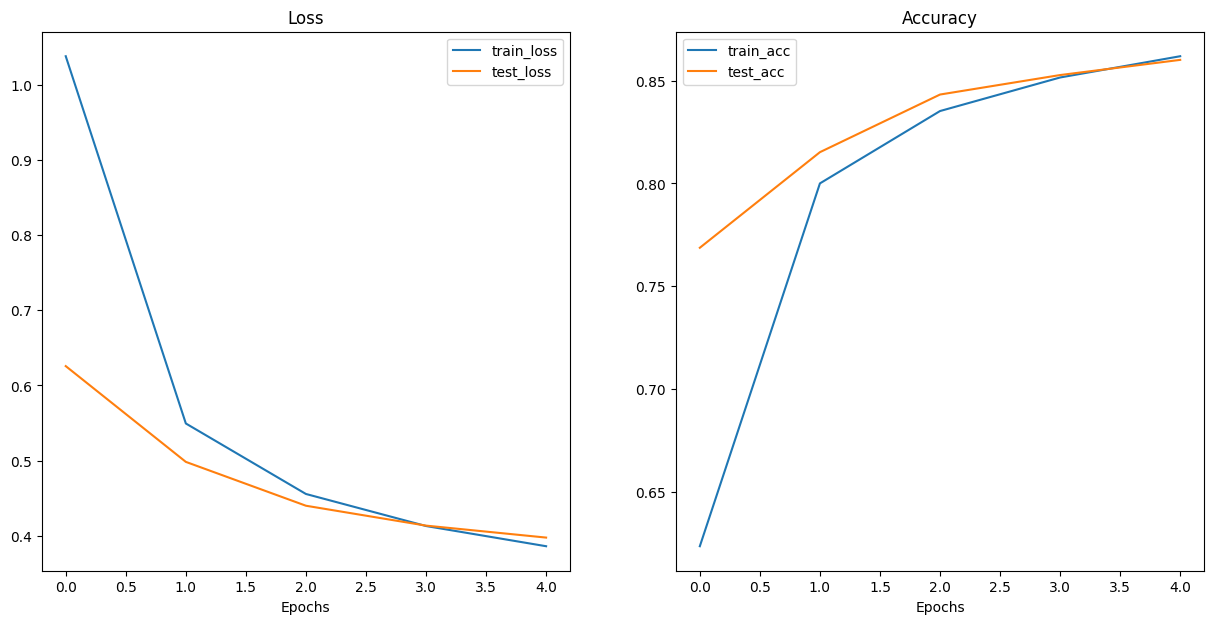

In [26]:
# graph for model without dropout
plot_results(results)

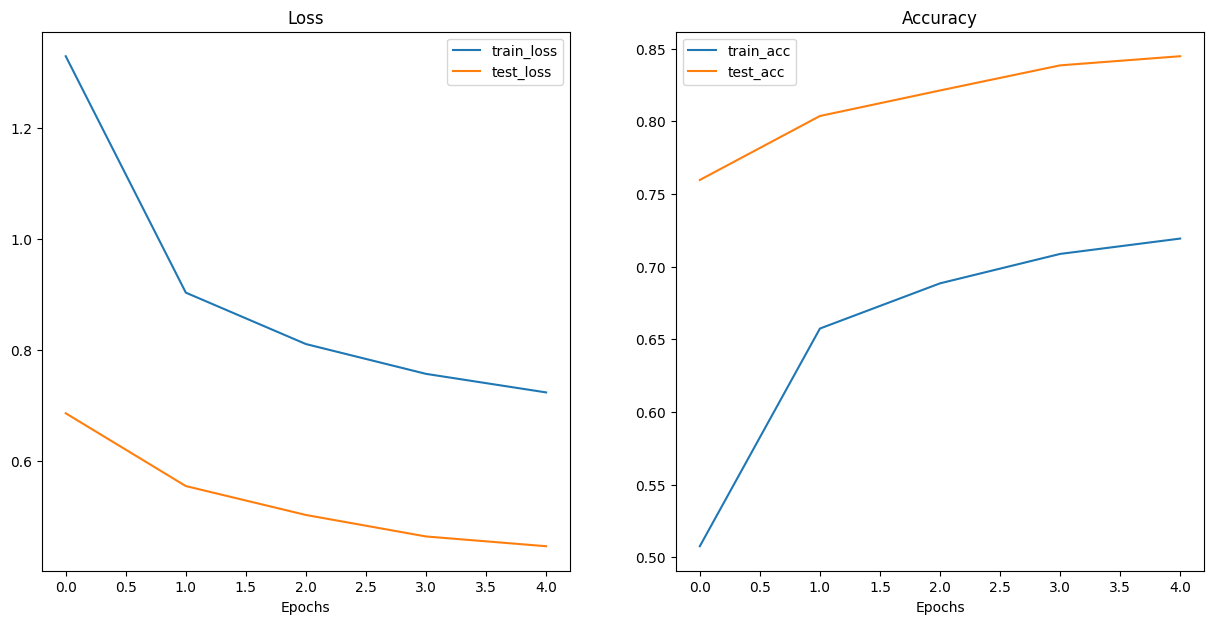

In [27]:
# graph for model with dropout
plot_results(dropout_results)

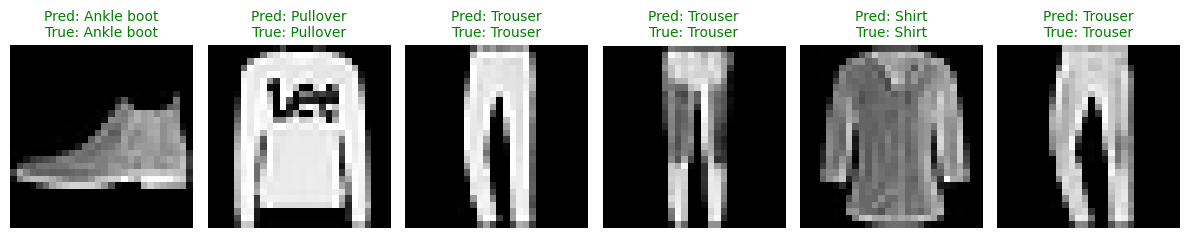

In [30]:
show_predictions(model_0, test_dataloader, class_names, DEVICE)

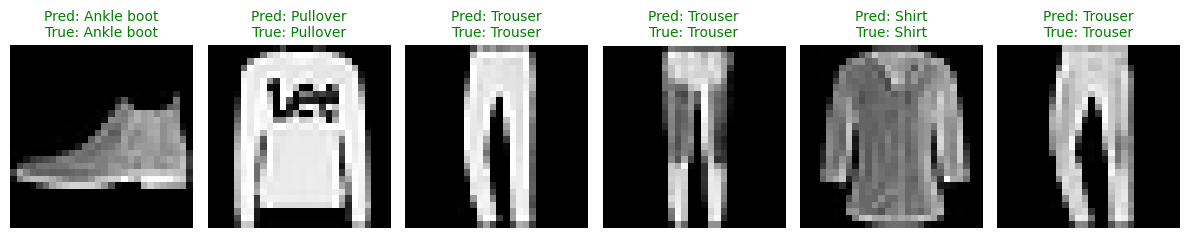

In [29]:
show_predictions(model_1, test_dataloader, class_names, DEVICE)

✅ Accuracy: 86.01%

📊 Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.85      0.81      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.79      0.77      0.78      1000
       Dress       0.90      0.81      0.85      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.61      0.64      0.62      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.96      0.95      0.96      1000
  Ankle boot       0.94      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



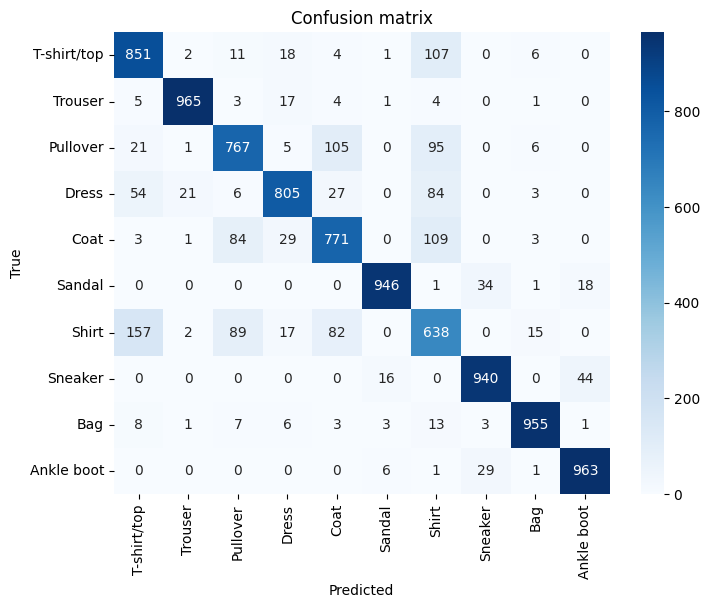

In [33]:
evaluate_model(model_0, test_dataloader, class_names, DEVICE)

In [ ]:
evaluate_model(model_0, test_dataloader, class_names, DEVICE)